1. Feature pipeline

1.1. Setup & cấu hình

- Mục tiêu: Khởi tạo môi trường chạy feature pipeline v5: import thư viện, cấu hình tham số xử lý song song, và chuẩn bị hằng số vật lý để hiệu chỉnh extinction.

- Import các thư viện xử lý dữ liệu (pandas/numpy), GP (sklearn.gaussian_process), và hiệu chỉnh bụi (extinction.fitzpatrick99).

- Tắt cảnh báo để log gọn hơn khi chạy nhiều split.

- Thiết lập tham số pipeline: số worker, dùng GP hay không, GP chỉ áp dụng cho band {g,r} để cân bằng chất lượng vs thời gian.

- Khai báo bước sóng trung tâm cho mỗi band và cache A(λ) khi Av=1 (A1_BY_BAND) để tính extinction nhanh bằng map (vectorized), tránh gọi hàm extinction lặp lại.

- EPS dùng để tránh chia cho 0 / log(0).

In [5]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
from extinction import fitzpatrick99

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.metrics import r2_score

from concurrent.futures import ProcessPoolExecutor, as_completed
import traceback

# -------------------------
# 0) SETTINGS
# -------------------------
N_WORKERS = os.cpu_count() or 4
USE_GP = True
GP_BANDS = {'g', 'r'}
GP_MIN_POINTS = 12
GP_MAX_POINTS = 25
GP_GRID_PTS = 40

DROP_NOISY_COUNT_FEATURES = True
FILLNA_VALUE = -999.0

# -------------------------
# 1) CONST
# -------------------------
WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}
DATA_ROOT = '/content'

# Cache A_lambda for Av=1 for each band
A1_BY_BAND = {band: float(fitzpatrick99(np.array([lam], dtype=float), 1.0)[0])
              for band, lam in WAVELENGTHS.items()}

EPS = 1e-9

1.2. Một số hàm tiện ích

Mục tiêu: Tập hợp các hàm tiện ích để trích xuất feature ổn định, nhanh và không phụ thuộc SciPy.

- _downsample_uniform: giảm số điểm light-curve theo lấy đều theo thời gian (giữ hình dạng tổng quát) giúp GP chạy nhanh hơn.

- _safe_percentile: tính percentile an toàn khi mảng rỗng.

- _kurtosis_excess: tính excess kurtosis (độ nhọn phân phối) bằng NumPy thuần.

- _autocorr_lag1: tính tự tương quan lag-1 (ACF1) để đo tính “mượt / có cấu trúc” của chuỗi.

- fit_powerlaw_decay: fit phần decay theo dạng power-law trong miền log-log, trả về (slope, r2, n) để bắt tín hiệu TDE (gần luật ~ t^{-5/3}).

- gp_fit_features_fast: chạy Gaussian Process rút gọn (không tối ưu hyperparam để tăng tốc), chỉ lấy 2 chỉ số:

  +) gp_lml: log-marginal-likelihood (đo mức “fit được” của GP)

  +) gp_smooth_std: độ biến thiên của đường GP mean (độ “mượt”/smoothness)

In [6]:
# -------------------------
# 2) UTILS
# -------------------------
def _downsample_uniform(t, f, max_points=25):
    n = len(t)
    if n <= max_points:
        return t, f
    idx = np.linspace(0, n - 1, max_points).astype(int)
    return t[idx], f[idx]

def _safe_percentile(x, p):
    if len(x) == 0:
        return np.nan
    return float(np.nanpercentile(x, p))

def _kurtosis_excess(x):
    # excess kurtosis (no scipy)
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 4:
        return 0.0
    mu = np.mean(x)
    s2 = np.var(x) + EPS
    m4 = np.mean((x - mu) ** 4)
    return float(m4 / (s2 ** 2) - 3.0)

def _autocorr_lag1(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 3:
        return 0.0
    a = x[:-1]
    b = x[1:]
    a = a - a.mean()
    b = b - b.mean()
    den = (np.sqrt(np.sum(a*a)) * np.sqrt(np.sum(b*b)) + EPS)
    return float(np.sum(a*b) / den)

def fit_powerlaw_decay(t, f, t_peak):
    """Fit log(f)=a*log(t-t_peak)+b on decay part; return slope, r2, n."""
    m = (t > t_peak)
    t_d = t[m] - t_peak
    f_d = f[m]
    ok = (t_d > 0) & (f_d > 0) & np.isfinite(t_d) & np.isfinite(f_d)
    t_d, f_d = t_d[ok], f_d[ok]
    if len(t_d) < 4:
        return np.nan, np.nan, 0
    log_t = np.log(t_d)
    log_f = np.log(f_d)
    slope, intercept = np.polyfit(log_t, log_f, 1)
    pred = slope * log_t + intercept
    r2 = r2_score(log_f, pred) if len(log_f) >= 2 else np.nan
    return float(slope), float(r2), int(len(t_d))

def gp_fit_features_fast(t, f):
    """
    Very fast GP -> return only:
      - gp_lml
      - gp_smooth_std
    """
    ok = np.isfinite(t) & np.isfinite(f)
    t = t[ok]; f = f[ok]
    if len(t) < GP_MIN_POINTS:
        return np.nan, np.nan

    order = np.argsort(t)
    t = t[order]; f = f[order]
    t, f = _downsample_uniform(t, f, max_points=GP_MAX_POINTS)
    X = t.reshape(-1, 1)

    kernel = ConstantKernel(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=1e-3)

    try:
        gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=0.0,
            normalize_y=True,
            optimizer=None,      # speed
            random_state=42
        )
        gp.fit(X, f)
        gp_lml = float(gp.log_marginal_likelihood())

        t_grid = np.linspace(float(t.min()), float(t.max()), GP_GRID_PTS).reshape(-1, 1)
        mu = gp.predict(t_grid, return_std=False)
        gp_smooth_std = float(np.std(mu))
        return gp_lml, gp_smooth_std
    except Exception:
        return np.nan, np.nan

1.3. Trích xuất feature

Trích xuất feature theo từng object × band

Merge thông tin tĩnh (EBV, Z) vào light curve, ép kiểu numeric.

Thực hiện dust extinction correction để tạo CorrectedFlux, tính SNR, weight, weighted_val.

Group theo (object_id, Filter) và trích xuất các nhóm đặc trưng:

- thống kê phân phối (mean/std/quantile/skew/kurtosis/MAD/IQR),

- hình thái light curve (rise/fade/duration/asymmetry/peak),

- độ mượt & biến thiên (gradient/smooth_abs/jerk/roughness/ACF1/zero-crossings),

- AUC & tỉ lệ (auc_pos/auc_abs/tail/outlier),

- power-law decay (slope, r2, |slope+5/3|),

- GP features (chỉ cho band g,r).

Cuối cùng pivot về dạng wide: mỗi object có cột dạng g_mean, r_auc_pos_norm, … rồi merge ngược về bảng log theo object_id.

In [7]:
# -------------------------
# 3) CORE FEATURE EXTRACTION (per split file)
# -------------------------
def extract_features_v5(df_log_chunk, df_split):
    """
    Giữ toàn bộ v4 mạnh + thêm per-band features + thêm global aggregates.
    """

    # merge static info
    df = pd.merge(
        df_split,
        df_log_chunk[['object_id', 'EBV', 'Z']],
        on='object_id',
        how='left'
    )

    # enforce numeric
    df['EBV'] = pd.to_numeric(df['EBV'], errors='coerce').fillna(0.0).astype(float)
    df['Z']   = pd.to_numeric(df['Z'], errors='coerce').fillna(0.0).astype(float)

    df['Flux']       = pd.to_numeric(df['Flux'], errors='coerce').astype(float)
    df['Flux_err']   = pd.to_numeric(df['Flux_err'], errors='coerce').astype(float)
    df['Time (MJD)'] = pd.to_numeric(df['Time (MJD)'], errors='coerce').astype(float)

    # ---- extinction correction (faster mapping) ----
    # Av = 3.1 * EBV
    Av = (3.1 * df['EBV'].values.astype(float))
    A1 = df['Filter'].astype(str).map(A1_BY_BAND).fillna(0.0).values.astype(float)
    A_lambda = A1 * Av
    corrected = df['Flux'].values * (10.0 ** (A_lambda / 2.5))
    df['CorrectedFlux'] = corrected

    ferr = df['Flux_err'].values
    w = 1.0 / (ferr * ferr + EPS)
    df['weight'] = w
    df['weighted_val'] = df['CorrectedFlux'].values * w
    df['SNR'] = df['CorrectedFlux'].values / (ferr + EPS)

    grouped = df.groupby(['object_id', 'Filter'], sort=False)

    out_rows = []
    out_index = []

    for (obj_id, band), x in grouped:
        x = x.sort_values('Time (MJD)')
        t = x['Time (MJD)'].values.astype(float)
        f = x['CorrectedFlux'].values.astype(float)
        snr = x['SNR'].values.astype(float)
        ww = x['weight'].values.astype(float)
        wv = x['weighted_val'].values.astype(float)

        ok = np.isfinite(t) & np.isfinite(f)
        t2, f2 = t[ok], f[ok]
        snr2 = snr[ok]

        n_points = int(len(f2))
        count_all = int(len(x))

        d = {}

        if n_points > 0:
            f_max = float(np.nanmax(f2))
            f_min = float(np.nanmin(f2))
            f_mean = float(np.nanmean(f2))
            f_std = float(np.nanstd(f2)) if n_points > 1 else 0.0
            f_median = float(np.nanmedian(f2))

            q10 = _safe_percentile(f2, 10)
            q25 = _safe_percentile(f2, 25)
            q75 = _safe_percentile(f2, 75)
            q90 = _safe_percentile(f2, 90)

            iqr = float(q75 - q25) if np.isfinite(q25) and np.isfinite(q75) else np.nan
            mad = float(np.nanmedian(np.abs(f2 - f_median)))

            # skew (fast)
            if n_points > 2:
                s = (np.nanstd(f2) + EPS)
                f_skew = float(np.nanmean(((f2 - f_mean) / s) ** 3))
            else:
                f_skew = 0.0

            # kurtosis (new)
            f_kurt = _kurtosis_excess(f2)

            # weighted mean
            w_sum = float(np.nansum(ww))
            w_mean = float(np.nansum(wv) / w_sum) if w_sum > 0 else np.nan

            # time/shape
            idx_peak = int(np.nanargmax(f2))
            t_peak = float(t2[idx_peak])
            t_start = float(np.nanmin(t2))
            t_end = float(np.nanmax(t2))

            rise = float(t_peak - t_start)
            fade = float(t_end - t_peak)
            dur = float(t_end - t_start)
            asymmetry = (fade / (rise + EPS)) if rise > 0 else np.nan

            # gradients
            if n_points > 1:
                dt = np.diff(t2) + 1e-6
                df_ = np.diff(f2)
                g = df_ / dt
                max_gradient = float(np.nanmax(g))
                min_gradient = float(np.nanmin(g))

                # smoothness/jerk (new)
                smooth_abs = float(np.mean(np.abs(df_))) / (abs(f_max - f_min) + EPS)
                jerk = float(np.mean(np.abs(np.diff(g)))) if len(g) > 2 else 0.0
            else:
                max_gradient = 0.0
                min_gradient = 0.0
                smooth_abs = 0.0
                jerk = 0.0

            # cadence stats
            if n_points > 1:
                dtt = np.diff(t2)
                cadence_mean = float(np.nanmean(dtt))
                cadence_std = float(np.nanstd(dtt)) if len(dtt) > 1 else 0.0
                max_gap = float(np.nanmax(dtt))
            else:
                cadence_mean = np.nan
                cadence_std = np.nan
                max_gap = np.nan

            # fractions / AUC
            halfmax = 0.5 * f_max
            frac_above_halfmax = float(np.mean(f2 >= halfmax)) if np.isfinite(halfmax) else np.nan

            frac_negative = float(np.mean(f2 < 0))
            frac_positive = float(np.mean(f2 > 0))

            # zero crossings (sign flips)
            sgn = np.sign(f2)
            if len(sgn) > 1:
                # treat zeros as previous sign (small loop but fast; n_points <= ~few dozens)
                for i in range(1, len(sgn)):
                    if sgn[i] == 0:
                        sgn[i] = sgn[i-1]
                zero_crossings = float(np.sum(sgn[1:] * sgn[:-1] < 0))
            else:
                zero_crossings = 0.0

            # roughness
            amp = (f_max - f_min) if np.isfinite(f_max) and np.isfinite(f_min) else 0.0
            roughness = float(np.mean(np.abs(np.diff(f2)))) / (abs(amp) + EPS) if n_points > 1 else 0.0

            # variability index
            variability_index = float(f_std / (abs(f_mean) + EPS)) if np.isfinite(f_mean) else np.nan

            # amplitude norm (new)
            amplitude_norm = float(amp / (abs(f_median) + EPS)) if np.isfinite(f_median) else np.nan

            # AUC features
            try:
                f_pos = np.where(f2 > 0, f2, 0.0)
                auc_pos = float(np.trapezoid(f_pos, t2)) if n_points > 1 else 0.0
                auc_abs = float(np.trapezoid(np.abs(f2), t2)) if n_points > 1 else 0.0
            except Exception:
                auc_pos = np.nan
                auc_abs = np.nan

            # normalized AUC
            auc_pos_norm = float(auc_pos / (dur + EPS)) if np.isfinite(auc_pos) and dur > 0 else np.nan
            auc_abs_norm = float(auc_abs / (dur + EPS)) if np.isfinite(auc_abs) and dur > 0 else np.nan

            # peak ratios
            peak_to_median = float(f_max / (abs(f_median) + EPS)) if np.isfinite(f_median) else np.nan
            peak_time_norm = float((t_peak - t_start) / (dur + EPS)) if dur > 0 else np.nan

            # normalized range by duration (new)
            range_over_dur = float(amp / (dur + EPS)) if dur > 0 else np.nan

            # power-law decay
            decay_slope, decay_r2, decay_n = fit_powerlaw_decay(t2, f2, t_peak)
            decay_slope_to_tde = abs(decay_slope + (5/3)) if np.isfinite(decay_slope) else np.nan

            # SNR stats
            snr_peak = float(np.nanmax(snr2)) if len(snr2) else np.nan
            snr_mean = float(np.nanmean(snr2)) if len(snr2) else np.nan
            snr_std = float(np.nanstd(snr2)) if len(snr2) > 1 else 0.0
            snr_auc_pos = float(np.trapezoid(np.where(snr2 > 0, snr2, 0.0), t2)) if n_points > 1 else 0.0

            # SNR AUC abs (new)
            snr_auc_abs = float(np.trapezoid(np.abs(snr2), t2)) if n_points > 1 else 0.0
            snr_auc_abs_norm = float(snr_auc_abs / (dur + EPS)) if dur > 0 else np.nan

            # autocorr lag-1 on flux (new)
            acf1 = _autocorr_lag1(f2)

            # outlier/tail ratios (new)
            # - fraction beyond median +/- 3*MAD
            thr = 3.0 * (mad + EPS)
            outlier_frac = float(np.mean(np.abs(f2 - f_median) > thr)) if np.isfinite(mad) else 0.0
            # - tail ratio (q90-q50)/(q50-q10)
            tail_ratio = float((q90 - f_median) / (f_median - q10 + EPS)) if np.isfinite(q10) and np.isfinite(q90) else np.nan

            # GP only for selected bands
            gp_lml, gp_smooth_std = (np.nan, np.nan)
            if USE_GP and (str(band) in GP_BANDS):
                gp_lml, gp_smooth_std = gp_fit_features_fast(t2, f2)

            d.update({
                # base stats
                'mean': f_mean,
                'median': f_median,
                'max': f_max,
                'min': f_min,
                'std': f_std,
                'skew': f_skew,
                'kurt': f_kurt,                 # NEW
                'q10': q10,                     # NEW
                'q25': q25,
                'q75': q75,
                'q90': q90,                     # NEW
                'iqr': iqr,
                'mad': mad,
                'w_mean': w_mean,

                # amplitude
                'amplitude': amp,
                'amplitude_norm': amplitude_norm,     # NEW

                # time/cadence
                'rise_time': rise,
                'fade_time': fade,
                'duration': dur,
                'asymmetry': asymmetry,
                'cadence_mean': cadence_mean,
                'cadence_std': cadence_std,
                'max_gap': max_gap,
                'peak_time_norm': peak_time_norm,
                'range_over_dur': range_over_dur,     # NEW

                # gradients
                'max_gradient': max_gradient,
                'min_gradient': min_gradient,
                'smooth_abs': smooth_abs,             # NEW
                'jerk': jerk,                         # NEW

                # shape / auc
                'frac_above_halfmax': frac_above_halfmax,
                'auc_pos': auc_pos,
                'auc_abs': auc_abs,
                'auc_pos_norm': auc_pos_norm,
                'auc_abs_norm': auc_abs_norm,
                'peak_to_median': peak_to_median,

                # anti-AGN / variability
                'frac_negative': frac_negative,
                'frac_positive': frac_positive,
                'zero_crossings': zero_crossings,
                'roughness': roughness,
                'variability_index': variability_index,
                'acf1': acf1,                         # NEW
                'outlier_frac': outlier_frac,         # NEW
                'tail_ratio': tail_ratio,             # NEW

                # power-law
                'decay_slope': decay_slope,
                'decay_r2': decay_r2,
                'decay_n': int(decay_n),
                'decay_slope_to_tde': decay_slope_to_tde,

                # snr
                'snr_peak': snr_peak,
                'snr_mean': snr_mean,
                'snr_std': snr_std,
                'snr_auc_pos': snr_auc_pos,
                'snr_auc_abs': snr_auc_abs,           # NEW
                'snr_auc_abs_norm': snr_auc_abs_norm, # NEW

                # GP
                'gp_lml': gp_lml,
                'gp_smooth_std': gp_smooth_std,

                # counts (optional)
                'n_points': n_points,
                'count': count_all,
            })
        else:
            # empty band -> keep NaNs
            keys = [
                'mean','median','max','min','std','skew','kurt','q10','q25','q75','q90','iqr','mad','w_mean',
                'amplitude','amplitude_norm',
                'rise_time','fade_time','duration','asymmetry','cadence_mean','cadence_std','max_gap','peak_time_norm','range_over_dur',
                'max_gradient','min_gradient','smooth_abs','jerk',
                'frac_above_halfmax','auc_pos','auc_abs','auc_pos_norm','auc_abs_norm','peak_to_median',
                'frac_negative','frac_positive','zero_crossings','roughness','variability_index','acf1','outlier_frac','tail_ratio',
                'decay_slope','decay_r2','decay_n','decay_slope_to_tde',
                'snr_peak','snr_mean','snr_std','snr_auc_pos','snr_auc_abs','snr_auc_abs_norm',
                'gp_lml','gp_smooth_std',
                'n_points','count'
            ]
            for k in keys:
                d[k] = np.nan

        out_rows.append(d)
        out_index.append((obj_id, str(band)))

    feats = pd.DataFrame(out_rows, index=pd.MultiIndex.from_tuples(out_index, names=['object_id', 'Filter']))
    feats = feats.unstack(level='Filter')

    # flatten columns: band_feat
    feats.columns = [f'{band}_{feat}' for feat, band in feats.columns]
    feats = feats.reset_index()

    # merge back
    out = pd.merge(df_log_chunk, feats, on='object_id', how='left')
    return out

1.4. WORKER + PREPARE DATA + RUN

1.4.1 _process_one_split_proc

- Mục tiêu: Xử lý một split: đọc file light-curve tương ứng, chuẩn hoá tên cột, gọi extract_features_v5, và bắt lỗi đầy đủ (traceback) để debug khi chạy song song.

1.4.2 _add_cross_band_aggregates

- Mục tiêu: Tạo feature tổng hợp đa băng theo từng object để giúp Stage-1 XGB xếp hạng tốt hơn: thống kê band đạt peak, trung bình/độ lệch amplitude-duration-roughness, tổng zero-crossings, và “robust colors” (w_mean/median/max + log-ratio).

1.4.3 prepare_data(...) + RUN train/test

- Mục tiêu: Chạy pipeline cho toàn bộ dữ liệu:

- Đọc train_log/test_log, chia theo split, chạy song song bằng ProcessPoolExecutor (có test 1 split trước để đảm bảo logic đúng).

- Ghép kết quả các split, thêm luminosity theo Z, thêm cross-band aggregates.

- Ép kiểu numeric, fill missing bằng FILLNA_VALUE, và drop một số “count features” nhiễu nếu bật DROP_NOISY_COUNT_FEATURES.

- Cuối cùng tạo ra full_train_data và full_test_data dùng cho bước train.

In [8]:
# -------------------------
# 4) WORKER
# -------------------------
def _process_one_split_proc(split_name, df_chunk_dict, split_file_name):
    try:
        df_chunk = pd.DataFrame(df_chunk_dict)
        path = os.path.join(DATA_ROOT, split_name, split_file_name)
        df_split = pd.read_csv(path)

        # normalize col names
        if 'Filter' not in df_split.columns and 'filter' in df_split.columns:
            df_split = df_split.rename(columns={'filter':'Filter'})
        if 'Time (MJD)' not in df_split.columns and 'Time' in df_split.columns:
            df_split = df_split.rename(columns={'Time':'Time (MJD)'})

        out = extract_features_v5(df_chunk, df_split)
        if out is None or len(out) == 0:
            return split_name, None, "Output empty"
        return split_name, out, None

    except Exception as e:
        err = f"{type(e).__name__}: {e}\n{traceback.format_exc()}"
        return split_name, None, err

# -------------------------
# 5) PREPARE DATA (train/test)
# -------------------------
def _add_cross_band_aggregates(final_df):
    """
    Global per-object aggregates across bands.
    Những feature này thường giúp Stage-1 XGB ordering ổn hơn.
    """
    bands = ['u','g','r','i','z','y']

    # convenience getters
    def has(col): return col in final_df.columns

    # max across band max (peak proxy)
    max_cols = [f'{b}_max' for b in bands if has(f'{b}_max')]
    med_cols = [f'{b}_median' for b in bands if has(f'{b}_median')]
    wm_cols  = [f'{b}_w_mean' for b in bands if has(f'{b}_w_mean')]
    amp_cols = [f'{b}_amplitude' for b in bands if has(f'{b}_amplitude')]
    skew_cols= [f'{b}_skew' for b in bands if has(f'{b}_skew')]
    dur_cols = [f'{b}_duration' for b in bands if has(f'{b}_duration')]
    rough_cols = [f'{b}_roughness' for b in bands if has(f'{b}_roughness')]
    zc_cols = [f'{b}_zero_crossings' for b in bands if has(f'{b}_zero_crossings')]

    if max_cols:
        mx = final_df[max_cols].values.astype(float)
        final_df['bandmax_max'] = np.nanmax(mx, axis=1)
        final_df['bandmax_min'] = np.nanmin(mx, axis=1)
        final_df['bandmax_mean']= np.nanmean(mx, axis=1)
        final_df['bandmax_std'] = np.nanstd(mx, axis=1)
        final_df['bandmax_span']= final_df['bandmax_max'] - final_df['bandmax_min']

        # which band peaks (0..len-1) (model can learn pattern)
        final_df['bandmax_argmax'] = np.nanargmax(mx, axis=1).astype(float)

    if amp_cols:
        aa = final_df[amp_cols].values.astype(float)
        final_df['amp_mean_across_bands'] = np.nanmean(aa, axis=1)
        final_df['amp_std_across_bands']  = np.nanstd(aa, axis=1)

    if skew_cols:
        ss = final_df[skew_cols].values.astype(float)
        final_df['skew_mean_across_bands'] = np.nanmean(ss, axis=1)
        final_df['skew_std_across_bands']  = np.nanstd(ss, axis=1)

    if dur_cols:
        dd = final_df[dur_cols].values.astype(float)
        final_df['dur_mean_across_bands'] = np.nanmean(dd, axis=1)
        final_df['dur_std_across_bands']  = np.nanstd(dd, axis=1)

    if rough_cols:
        rr = final_df[rough_cols].values.astype(float)
        final_df['rough_mean_across_bands'] = np.nanmean(rr, axis=1)
        final_df['rough_std_across_bands']  = np.nanstd(rr, axis=1)

    if zc_cols:
        zz = final_df[zc_cols].values.astype(float)
        final_df['zc_sum_across_bands'] = np.nansum(zz, axis=1)

    # more robust colors (median & max) in addition to w_mean
    pairs = [('u','g'), ('g','r'), ('r','i'), ('i','z'), ('z','y')]
    for c1, c2 in pairs:
        # w_mean colors (keep, as old)
        f1 = f'{c1}_w_mean'; f2 = f'{c2}_w_mean'
        if has(f1) and has(f2):
            final_df[f'{c1}_minus_{c2}'] = final_df[f1] - final_df[f2]
            final_df[f'log_{c1}_over_{c2}'] = np.log1p(np.abs(final_df[f1])) - np.log1p(np.abs(final_df[f2]))

        # median colors (NEW)
        m1 = f'{c1}_median'; m2 = f'{c2}_median'
        if has(m1) and has(m2):
            final_df[f'{c1}_minus_{c2}_med'] = final_df[m1] - final_df[m2]
            final_df[f'log_{c1}_over_{c2}_med'] = np.log1p(np.abs(final_df[m1])) - np.log1p(np.abs(final_df[m2]))

        # max colors (NEW)
        x1 = f'{c1}_max'; x2 = f'{c2}_max'
        if has(x1) and has(x2):
            final_df[f'{c1}_minus_{c2}_max'] = final_df[x1] - final_df[x2]
            final_df[f'log_{c1}_over_{c2}_max'] = np.log1p(np.abs(final_df[x1])) - np.log1p(np.abs(final_df[x2]))

    return final_df

def prepare_data(log_file, split_file_name, is_train=True, n_workers=N_WORKERS, debug_single_first=True):
    df_log_path = os.path.join(DATA_ROOT, log_file)
    df_log = pd.read_csv(df_log_path)

    # drop useless column
    if 'English Translation' in df_log.columns:
        df_log = df_log.drop(['English Translation'], axis=1)

    if 'Z_err' in df_log.columns:
        df_log['Z_err'] = pd.to_numeric(df_log['Z_err'], errors='coerce').fillna(0.0)

    grouped_logs = list(df_log.groupby('split'))
    n_splits = len(grouped_logs)

    n_workers = int(min(max(1, n_workers), n_splits))
    print(f"n_splits={n_splits} | dùng n_workers={n_workers}")
    print("Splits (first 5):", [s for s, _ in grouped_logs[:5]], "...")

    tasks = []
    for split_name, chunk in grouped_logs:
        tasks.append((split_name, chunk.copy().to_dict(orient='list'), split_file_name))

    if debug_single_first:
        test_split, test_chunk = grouped_logs[0][0], grouped_logs[0][1].copy()
        print(f"\n[DEBUG] Single test split: {test_split}")
        s, out, err = _process_one_split_proc(test_split, test_chunk.to_dict(orient='list'), split_file_name)
        if err is not None:
            print("\n❌ Single FAILED:")
            print(err)
            raise RuntimeError("Single-process fail -> sửa lỗi logic trước.")
        print(f"✅ Single OK. rows={len(out)} cols={out.shape[1]}\n")

    results, errors = [], []

    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        futures = [ex.submit(_process_one_split_proc, split_name, chunk_dict, split_csv)
                   for split_name, chunk_dict, split_csv in tasks]

        done = 0
        for fut in as_completed(futures):
            split_name, out, err = fut.result()
            done += 1
            if err is not None:
                errors.append((split_name, err))
            else:
                results.append(out)
            if done % 2 == 0 or done == len(futures):
                print(f"Done {done}/{len(futures)} splits")

    if not results:
        print("\n❌ TẤT CẢ SPLIT ĐỀU LỖI. 3 lỗi đầu tiên:\n")
        for i, (s, e) in enumerate(errors[:3], 1):
            print(f"--- Error #{i} | split={s} ---")
            print(e, "\n")
        raise RuntimeError("Không tạo được feature nào. Xem lỗi phía trên.")

    if errors:
        print(f"\n⚠️ Có {len(errors)}/{n_splits} split bị lỗi. 3 lỗi đầu:\n")
        for i, (s, e) in enumerate(errors[:3], 1):
            print(f"--- Error #{i} | split={s} ---")
            print(e, "\n")

    final_df = pd.concat(results, ignore_index=True)
    del results
    gc.collect()

    # Luminosity
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        col = f'{band}_max'
        if col in final_df.columns and 'Z' in final_df.columns:
            final_df[f'{band}_luminosity'] = final_df[col] * (final_df['Z'].astype(float) ** 2)

    # add cross-band aggregates (NEW)
    final_df = _add_cross_band_aggregates(final_df)

    # numeric cast
    cols_excl = ['object_id', 'split', 'target', 'SpecType']
    num_cols = [c for c in final_df.columns if c not in cols_excl]
    for c in num_cols:
        final_df[c] = pd.to_numeric(final_df[c], errors='coerce')

    # optionally drop noisy features
    if DROP_NOISY_COUNT_FEATURES:
        drop_cols = []
        for band in ['u','g','r','i','z','y']:
            for name in ['count', 'n_points', 'snr_mean']:
                cc = f'{band}_{name}'
                if cc in final_df.columns:
                    drop_cols.append(cc)
        if drop_cols:
            final_df = final_df.drop(columns=drop_cols, errors='ignore')
            print(f"🧹 Dropped noisy cols: {len(drop_cols)}")
            num_cols = [c for c in num_cols if c in final_df.columns]

    final_df[num_cols] = final_df[num_cols].fillna(FILLNA_VALUE)
    return final_df

# -------------------------
# 6) RUN
# -------------------------
print("1) Đang xử lý tập Train (v5)...")
full_train_data = prepare_data('train_log.csv', 'train_full_lightcurves.csv', is_train=True, n_workers=N_WORKERS)
print(f"-> Train Shape: {full_train_data.shape}")

print("\n2) Đang xử lý tập Test (v5)...")
full_test_data = prepare_data('test_log.csv', 'test_full_lightcurves.csv', is_train=False, n_workers=N_WORKERS)
print(f"-> Test Shape: {full_test_data.shape}")

print("\n✅ Done feature extraction v5.")


1) Đang xử lý tập Train (v5)...
n_splits=20 | dùng n_workers=20
Splits (first 5): ['split_01', 'split_02', 'split_03', 'split_04', 'split_05'] ...

[DEBUG] Single test split: split_01
✅ Single OK. rows=155 cols=349

Done 2/20 splits
Done 4/20 splits
Done 6/20 splits
Done 8/20 splits
Done 10/20 splits
Done 12/20 splits
Done 14/20 splits
Done 16/20 splits
Done 18/20 splits
Done 20/20 splits
🧹 Dropped noisy cols: 18
-> Train Shape: (3043, 382)

2) Đang xử lý tập Test (v5)...
n_splits=20 | dùng n_workers=20
Splits (first 5): ['split_01', 'split_02', 'split_03', 'split_04', 'split_05'] ...

[DEBUG] Single test split: split_01
✅ Single OK. rows=364 cols=348

Done 2/20 splits
Done 4/20 splits
Done 6/20 splits
Done 8/20 splits
Done 10/20 splits
Done 12/20 splits
Done 14/20 splits
Done 16/20 splits
Done 18/20 splits
Done 20/20 splits
🧹 Dropped noisy cols: 18
-> Test Shape: (7135, 381)

✅ Done feature extraction v5.


2. Train model

2.1 Import + settings

- Cell này khởi tạo toàn bộ cấu hình cho pipeline train 2-stage:

- Stage 1 (XGBoost): ưu tiên recall cao → dùng để xếp hạng và chọn candidate top-K có khả năng là TDE.

- Stage 2 (CatBoost): train trên hard negatives + positives → tăng precision, lọc nhiễu và “tinh chỉnh” trong top-K.

- Kết hợp seed bagging + alpha search + rank/prob blending + rule-based chỉnh nhẹ để ổn định leaderboard và tránh phụ thuộc calibration.

In [9]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

print("=== TRAIN v5: XGB->CAT2 hard-neg + dynamic TOPK + seed bagging + alpha search + rank/prob/rule ===")

# -------------------------
# 0) SETTINGS
# -------------------------
N_FOLDS = 5
BASE_SEED = 42

# Bagging seeds (nhẹ, ổn định LB hơn)
SEED_LIST = [42, 202, 777]   # có thể giảm còn [42, 202] nếu muốn nhanh

# Stage-1 candidate TOPK (dynamic)
TOPK_MIN = 800
TOPK_MAX = 2200
VAL_POS_RECALL_TARGET = 0.98   # mục tiêu: giữ gần đủ positives trong candidate set
TEST_TOPK = 1600               # vẫn giữ fixed cho test (ổn định); có thể 1500/1800

# Hard-neg
HARD_NEG_RATIO = 8
USE_HARDNEG_MIX = True
MIX_FILTERED_FRAC = 0.60
CAT2_ES_ROUNDS = 200

# Missing / drop
MISSING_SENTINEL = -999
MISSING_FRAC_TH = 0.995
ENABLE_AUTO_DROP = True
DROP_IF_CONST = True
DROP_IF_MOSTLY_MISSING = True

UNSTABLE_EXACT = ["y_auc_abs_norm"]     # giữ như bạn đã test ổn :contentReference[oaicite:2]{index=2}
UNSTABLE_REGEX = []
ENABLE_UNSTABLE_REGEX_DROP = False

# Hard-neg filter percentiles
HN_PCTL_ZERO = 97
HN_PCTL_ROUGH = 97
HN_PCTL_FRACNEG = 97

# Rule weights (nhẹ) - sẽ sweep 1 chút khi alpha search
RULE_W_POS = 0.015
RULE_W_NEG = -0.008

# Alpha grid search
ALPHA_GRID = [0.25, 0.35, 0.40, 0.45, 0.55]


=== TRAIN v5: XGB->CAT2 hard-neg + dynamic TOPK + seed bagging + alpha search + rank/prob/rule ===


2.2. Chuẩn bị dữ liệu & tự động loại feature nhiễu

Mục tiêu:

- Chuẩn hoá dữ liệu đầu vào cho mô hình train:

- Tách feature matrix (X) và nhãn (y) từ output của feature pipeline v5.

- Đảm bảo train/test có cùng tập feature, kiểu dữ liệu numeric sạch.

- Tự động loại bỏ feature kém chất lượng (hằng số, thiếu quá nhiều, hoặc đã biết là không ổn định) để giảm nhiễu và overfitting.

In [10]:
# -------------------------
# 1) PREP DATA
# -------------------------
DROP_COLS_TRAIN = ['object_id', 'split', 'target', 'SpecType']
DROP_COLS_TEST  = ['object_id', 'split', 'SpecType']

# full_train_data / full_test_data phải có sẵn từ pipeline features
X = full_train_data.drop(columns=DROP_COLS_TRAIN, errors='ignore').copy()
y = full_train_data['target'].astype(int).copy()

X_test = full_test_data.drop(columns=DROP_COLS_TEST, errors='ignore').copy()
X_test = X_test.reindex(columns=X.columns, fill_value=MISSING_SENTINEL)

def clean_col(c):
    c = re.sub(r'[^A-Za-z0-9_]+', '_', str(c))
    c = re.sub(r'__+', '_', c).strip('_')
    return c

X.columns = [clean_col(c) for c in X.columns]
X_test.columns = [clean_col(c) for c in X_test.columns]

X = X.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

X = X.replace([np.inf, -np.inf], np.nan).fillna(MISSING_SENTINEL)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(MISSING_SENTINEL)

print("Train X:", X.shape, "Test X:", X_test.shape)
print("Pos rate:", y.mean(), "| pos:", int(y.sum()), "neg:", int((1-y).sum()))

# -------------------------
# 2) AUTO DROP
# -------------------------
dropped = []
if ENABLE_AUTO_DROP:
    if DROP_IF_MOSTLY_MISSING:
        missing_frac = (X == MISSING_SENTINEL).mean(axis=0)
        dropped += missing_frac[missing_frac >= MISSING_FRAC_TH].index.tolist()

    if DROP_IF_CONST:
        nun = X.nunique(dropna=False)
        dropped += nun[nun <= 1].index.tolist()

    dropped = sorted(set(dropped))
    if dropped:
        print(f"\nAuto drop feats: {len(dropped)}")
        print("First 30:", dropped[:30], "..." if len(dropped) > 30 else "")
        X = X.drop(columns=dropped, errors='ignore')
        X_test = X_test.drop(columns=dropped, errors='ignore')

unstable_present = [c for c in UNSTABLE_EXACT if c in X.columns]
if unstable_present:
    print(f"\n🧹 Drop unstable feats (exact): {unstable_present}")
    X = X.drop(columns=unstable_present)
    X_test = X_test.drop(columns=unstable_present)

if ENABLE_UNSTABLE_REGEX_DROP and UNSTABLE_REGEX:
    rx = re.compile("|".join(f"(?:{p})" for p in UNSTABLE_REGEX))
    to_drop_rx = [c for c in X.columns if rx.match(c)]
    if to_drop_rx:
        print(f"\n🧹 Drop unstable feats (regex): {len(to_drop_rx)}")
        print("First 30:", to_drop_rx[:30], "..." if len(to_drop_rx) > 30 else "")
        X = X.drop(columns=to_drop_rx, errors='ignore')
        X_test = X_test.drop(columns=to_drop_rx, errors='ignore')

print("\nAfter drop -> Train X:", X.shape, "Test X:", X_test.shape)
feature_names = X.columns.tolist()


Train X: (3043, 378) Test X: (7135, 378)
Pos rate: 0.04863621426224121 | pos: 148 neg: 2895

Auto drop feats: 9
First 30: ['Z_err', 'i_gp_lml', 'i_gp_smooth_std', 'u_gp_lml', 'u_gp_smooth_std', 'y_gp_lml', 'y_gp_smooth_std', 'z_gp_lml', 'z_gp_smooth_std'] 

🧹 Drop unstable feats (exact): ['y_auc_abs_norm']

After drop -> Train X: (3043, 368) Test X: (7135, 368)


2.3 Thiết lập tham số mô hình

Mục tiêu: Khởi tạo tham số cho pipeline 2-stage gồm:

- Stage 1 – XGBoost: ưu tiên recall cao để xếp hạng và chọn candidate.

- Stage 2 – CatBoost: tinh chỉnh trong candidate set, tăng precision.

In [11]:
# -------------------------
# 3) MODEL PARAMS
# -------------------------
pos = float(y.sum())
neg = float((1 - y).sum())
scale_pos_weight = max(1.0, neg / max(1.0, pos))
print(f"\n[INFO] scale_pos_weight (auto) = {scale_pos_weight:.4f}")

# Stage-1 XGB params (giữ gần như bản bạn đang dùng, chỉ n_estimators hơi tăng + early stopping)
xgb_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'max_depth': 8,
    'scale_pos_weight': scale_pos_weight,
    'reg_alpha': 0.35,
    'reg_lambda': 7.8,
    'subsample': 0.70,
    'colsample_bytree': 0.67,
    'min_child_weight': 10,
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'tree_method': 'hist'
}

# Stage-2 CAT2 params (giữ tương tự)
cat2_params = {
    'iterations': 8000,
    'learning_rate': 0.03,
    'depth': 9,
    'l2_leaf_reg': 9.36,
    'random_strength': 0.32,
    'bagging_temperature': 0.01,
    'auto_class_weights': 'Balanced',
    'loss_function': 'Logloss',
    'verbose': 0,
    'allow_writing_files': False
}



[INFO] scale_pos_weight (auto) = 19.5608


2.4. Các hàm hỗ trợ cho ensemble + chọn ngưỡng + hard-neg

- rank01: chuyển score → rank [0,1] để blend không phụ thuộc calibration.

- apply_rules: thêm physics-based rules nhẹ dựa trên r_decay_r2 và r_decay_slope_to_tde (chỉ nudging, không thay model).

- hardneg_filter_pool: lọc hard-negative pool dựa trên percentile các feature anti-AGN (zero_crossings/roughness/frac_negative).

- dynamic_topk_for_val: chọn K nhỏ nhất sao cho recall positives trong top-K đạt mục tiêu.

- best_f1_threshold_fast: tìm threshold tối ưu F1 theo cách quét sorted score (nhanh hơn grid).

- threshold_for_k: lấy threshold sao cho đúng top-K positives.

- save_sub: xuất file submission theo threshold.

In [12]:
# -------------------------
# 4) HELPERS
# -------------------------
def rank01(a):
    r = pd.Series(a).rank(method="average").values
    return r / len(r)

def _col(df, name):
    return df[name].values if name in df.columns else None

def apply_rules(df_feat, base_score, w_pos=RULE_W_POS, w_neg=RULE_W_NEG):
    # mild rules như bạn đang dùng :contentReference[oaicite:3]{index=3}
    s = base_score.astype(float).copy()
    r_decay_r2  = _col(df_feat, "r_decay_r2")
    r_slope_to  = _col(df_feat, "r_decay_slope_to_tde")

    if r_decay_r2 is not None:
        q80 = np.nanpercentile(r_decay_r2, 80)
        q20 = np.nanpercentile(r_decay_r2, 20)
        s += np.where(r_decay_r2 >= q80, w_pos, 0.0)
        s += np.where(r_decay_r2 <= q20, w_neg, 0.0)

    if r_slope_to is not None:
        q20 = np.nanpercentile(r_slope_to, 20)
        q80 = np.nanpercentile(r_slope_to, 80)
        s += np.where(r_slope_to <= q20, w_pos, 0.0)
        s += np.where(r_slope_to >= q80, w_neg, 0.0)

    return s

def hardneg_filter_pool(X_tr, neg_idx, prefix="r_"):
    prefixes = [prefix, "g_", "u_"]
    for pre in prefixes:
        c_zero = f"{pre}zero_crossings"
        c_rough = f"{pre}roughness"
        c_fracneg = f"{pre}frac_negative"
        cols = [c for c in [c_zero, c_rough, c_fracneg] if c in X_tr.columns]
        if len(cols) == 0:
            continue

        Xn = X_tr.iloc[neg_idx]
        keep = np.ones(len(Xn), dtype=bool)

        if c_zero in X_tr.columns:
            z = Xn[c_zero].values
            keep &= (z <= np.nanpercentile(z, HN_PCTL_ZERO))

        if c_rough in X_tr.columns:
            r = Xn[c_rough].values
            keep &= (r <= np.nanpercentile(r, HN_PCTL_ROUGH))

        if c_fracneg in X_tr.columns:
            fn = Xn[c_fracneg].values
            keep &= (fn <= np.nanpercentile(fn, HN_PCTL_FRACNEG))

        filtered = neg_idx[keep]
        return filtered if len(filtered) > 0 else neg_idx

    return neg_idx

def dynamic_topk_for_val(p_val, y_val, target_recall=0.98, kmin=800, kmax=2200):
    """
    Chọn K nhỏ nhất sao cho recall positives trong top-K >= target_recall.
    Nếu positives quá ít/edge case -> fallback kmin.
    """
    yv = np.asarray(y_val).astype(int)
    pos_idx = np.where(yv == 1)[0]
    if len(pos_idx) == 0:
        return int(min(max(kmin, 200), len(p_val)))

    order = np.argsort(-p_val)
    pos_set = set(pos_idx.tolist())
    hit = 0
    need = int(np.ceil(target_recall * len(pos_idx)))

    for i, ix in enumerate(order, 1):
        if ix in pos_set:
            hit += 1
            if hit >= need:
                return int(np.clip(i, kmin, min(kmax, len(p_val))))
    return int(np.clip(len(p_val), kmin, min(kmax, len(p_val))))

def best_f1_threshold_fast(y_true, score):
    """
    Tìm threshold tối ưu F1 bằng cách quét theo sorted unique score (O(n log n)).
    """
    y_true = np.asarray(y_true).astype(int)
    score = np.asarray(score).astype(float)

    # sort by score desc
    order = np.argsort(-score)
    y_sorted = y_true[order]
    s_sorted = score[order]

    P = y_true.sum()
    if P == 0:
        return 0.0, 1.0

    tp = 0
    fp = 0
    best_f1 = -1.0
    best_th = 0.5

    # threshold at each unique score boundary
    # predict positive for all score >= th
    prev_s = None
    for i in range(len(s_sorted)):
        if y_sorted[i] == 1:
            tp += 1
        else:
            fp += 1

        # only evaluate when score changes (boundary)
        cur_s = s_sorted[i]
        nxt_s = s_sorted[i+1] if i+1 < len(s_sorted) else (cur_s - 1e-12)
        if prev_s is None or nxt_s != cur_s:
            fn = P - tp
            denom = (2*tp + fp + fn)
            f1 = (2*tp / denom) if denom > 0 else 0.0
            if f1 > best_f1:
                best_f1 = float(f1)
                best_th = float(cur_s)  # th = current score boundary
        prev_s = cur_s

    return best_f1, best_th

def threshold_for_k(score, k):
    s = np.asarray(score)
    if k <= 0:
        return 1.0
    if k >= len(s):
        return 0.0
    kth = np.partition(s, -k)[-k]
    return float(kth)

def save_sub(name, score, th):
    pred = (np.asarray(score) >= th).astype(int)
    sub = pd.DataFrame({"object_id": full_test_data["object_id"], "prediction": pred})
    fn = f"{name}.csv"
    sub.to_csv(fn, index=False)
    print(f"✅ Saved: {fn} | th={th:.6f} | positives={int(pred.sum())}")


2.5. CV TRAIN (seed bagging)

Huấn luyện CV theo seed-bagging và 2-stage pipeline.
Với mỗi seed trong SEED_LIST và mỗi fold:

1. Train XGB stage-1 → lấy OOF + test prob, đồng thời dùng prob train để hard-neg mining.

2. Tạo tập train cho CatBoost stage-2 = positives + hard negatives.

3. Trên validation, chọn dynamic TOPK theo mục tiêu recall positives, chỉ predict CatBoost trong candidate set (ngoài candidate = 0).

4. Trên test, dùng fixed TOPK để ổn định.
Cuối cùng, lấy trung bình OOF/test theo folds và theo seeds → tạo xgb_oof_mean/cat_oof_mean và xgb_test_mean/cat_test_mean.

In [13]:
# -------------------------
# 5) CV TRAIN (seed bagging)
# -------------------------
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=BASE_SEED)

# store OOF/test per seed
seed_oof_xgb = []
seed_test_xgb = []
seed_oof_cat = []
seed_test_cat = []

xgb_gain_maps_all = []
cat_imp_list_all = []

for seed in SEED_LIST:
    print(f"\n=========================")
    print(f"== Seed bag: {seed}")
    print(f"=========================")

    xgb_oof = np.zeros(len(X))
    xgb_test = np.zeros(len(X_test))
    cat_oof = np.zeros(len(X))
    cat_test = np.zeros(len(X_test))

    xgb_gain_maps = []
    cat_imp_list = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold}/{N_FOLDS} | seed={seed} ---")
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        # Stage-1 XGB
        params_fold = dict(xgb_params)
        params_fold['random_state'] = seed

        model_xgb = xgb.XGBClassifier(**params_fold, early_stopping_rounds=200)
        model_xgb.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        p_va_xgb = model_xgb.predict_proba(X_va)[:, 1]
        xgb_oof[va_idx] = p_va_xgb
        p_te_xgb = model_xgb.predict_proba(X_test)[:, 1]
        xgb_test += p_te_xgb / N_FOLDS

        f1_xgb, th_xgb = best_f1_threshold_fast(y_va, p_va_xgb)
        print(f"XGB fold-best F1={f1_xgb:.4f} @th≈{th_xgb:.6f}")

        booster = model_xgb.get_booster()
        xgb_gain_maps.append(booster.get_score(importance_type="gain"))

        # Hard-neg mining on TRAIN
        p_tr_xgb = model_xgb.predict_proba(X_tr)[:, 1]
        pos_tr = np.where(y_tr.values == 1)[0]
        neg_tr = np.where(y_tr.values == 0)[0]
        n_hard = min(len(neg_tr), HARD_NEG_RATIO * max(1, len(pos_tr)))

        if USE_HARDNEG_MIX:
            neg_filtered = hardneg_filter_pool(X_tr, neg_tr, prefix="r_")
            n_f = int(round(n_hard * MIX_FILTERED_FRAC))
            n_u = n_hard - n_f

            hard_f = neg_filtered[np.argsort(-p_tr_xgb[neg_filtered])[:min(n_f, len(neg_filtered))]]
            hard_u = neg_tr[np.argsort(-p_tr_xgb[neg_tr])[:min(n_u, len(neg_tr))]]
            hard_neg_local = np.unique(np.concatenate([hard_f, hard_u]))
        else:
            hard_neg_local = neg_tr[np.argsort(-p_tr_xgb[neg_tr])[:n_hard]]

        cat2_train_local = np.concatenate([pos_tr, hard_neg_local])
        X_tr_cat2 = X_tr.iloc[cat2_train_local]
        y_tr_cat2 = y_tr.iloc[cat2_train_local]

        # Dynamic TOPK for VALID candidates
        Kdyn = dynamic_topk_for_val(
            p_va_xgb, y_va.values,
            target_recall=VAL_POS_RECALL_TARGET,
            kmin=TOPK_MIN, kmax=TOPK_MAX
        )
        cand_local = np.argsort(-p_va_xgb)[:Kdyn]

        # Stage-2 CAT2
        cat_params_fold = dict(cat2_params)
        cat_params_fold['random_seed'] = seed

        model_cat2 = CatBoostClassifier(**cat_params_fold)
        model_cat2.fit(
            X_tr_cat2, y_tr_cat2,
            eval_set=(X_va.iloc[cand_local], y_va.iloc[cand_local]),
            early_stopping_rounds=CAT2_ES_ROUNDS
        )

        p_va_cat2 = np.zeros(len(va_idx), dtype=float)
        p_va_cat2[cand_local] = model_cat2.predict_proba(X_va.iloc[cand_local])[:, 1]
        cat_oof[va_idx] = p_va_cat2

        # Test candidates (fixed TEST_TOPK for stability)
        Kt = min(TEST_TOPK, len(X_test))
        cand_te = np.argsort(-p_te_xgb)[:Kt]
        p_te_cat2 = np.zeros(len(X_test), dtype=float)
        p_te_cat2[cand_te] = model_cat2.predict_proba(X_test.iloc[cand_te])[:, 1]
        cat_test += p_te_cat2 / N_FOLDS

        f1_cat2, th_cat2 = best_f1_threshold_fast(y_va, p_va_cat2)
        pos_in_cand = int(y_va.iloc[cand_local].sum())
        print(f"CAT2 fold-best F1={f1_cat2:.4f} @th≈{th_cat2:.6f} | Kdyn={Kdyn} | pos_in_cand={pos_in_cand}/{int(y_va.sum())}")
        print(f"[INFO] hard_neg={len(hard_neg_local)} | pos_tr={len(pos_tr)} | neg_tr={len(neg_tr)}")

        try:
            cat_imp_list.append(model_cat2.get_feature_importance(type="PredictionValuesChange"))
        except Exception:
            pass

    seed_oof_xgb.append(xgb_oof)
    seed_test_xgb.append(xgb_test)
    seed_oof_cat.append(cat_oof)
    seed_test_cat.append(cat_test)

    xgb_gain_maps_all.append(xgb_gain_maps)
    if len(cat_imp_list) > 0:
        cat_imp_list_all.append(np.vstack(cat_imp_list))

print("\n✅ Finished seed bagging CV.")

# Average across seeds
xgb_oof_mean = np.mean(np.vstack(seed_oof_xgb), axis=0)
xgb_test_mean = np.mean(np.vstack(seed_test_xgb), axis=0)
cat_oof_mean  = np.mean(np.vstack(seed_oof_cat), axis=0)
cat_test_mean = np.mean(np.vstack(seed_test_cat), axis=0)



== Seed bag: 42

--- Fold 1/5 | seed=42 ---
XGB fold-best F1=0.6441 @th≈0.497031
CAT2 fold-best F1=0.5714 @th≈0.301393 | Kdyn=609 | pos_in_cand=30/30
[INFO] hard_neg=580 | pos_tr=118 | neg_tr=2316

--- Fold 2/5 | seed=42 ---
XGB fold-best F1=0.5366 @th≈0.144832
CAT2 fold-best F1=0.5714 @th≈0.285858 | Kdyn=609 | pos_in_cand=30/30
[INFO] hard_neg=580 | pos_tr=118 | neg_tr=2316

--- Fold 3/5 | seed=42 ---
XGB fold-best F1=0.5867 @th≈0.233316
CAT2 fold-best F1=0.4688 @th≈0.274713 | Kdyn=609 | pos_in_cand=30/30
[INFO] hard_neg=585 | pos_tr=118 | neg_tr=2316

--- Fold 4/5 | seed=42 ---
XGB fold-best F1=0.5172 @th≈0.413786
CAT2 fold-best F1=0.4722 @th≈0.270340 | Kdyn=608 | pos_in_cand=29/29
[INFO] hard_neg=590 | pos_tr=119 | neg_tr=2316

--- Fold 5/5 | seed=42 ---
XGB fold-best F1=0.5714 @th≈0.595019
CAT2 fold-best F1=0.6557 @th≈0.261639 | Kdyn=608 | pos_in_cand=29/29
[INFO] hard_neg=584 | pos_tr=119 | neg_tr=2316

== Seed bag: 202

--- Fold 1/5 | seed=202 ---
XGB fold-best F1=0.6441 @th≈0.4

2.6. Mục tiêu

Tìm cách kết hợp tối ưu giữa score của Stage-1 (XGB) và Stage-2 (CatBoost) bằng cách:

- Sweep hệ số alpha trong phép blend

- So sánh probability blend vs rank-based blend

- Thử thêm rule-based adjustment nhẹ dựa trên feature vật lý

- Chọn biến thể có OOF F1 cao nhất

In [14]:
# -------------------------
# 6) Alpha search over variants
# -------------------------
def eval_variant(y_true, score):
    f1, th = best_f1_threshold_fast(y_true, score)
    return f1, th

def build_scores(alpha, wpos, wneg):
    oof_prob = alpha * xgb_oof_mean + (1 - alpha) * cat_oof_mean
    te_prob  = alpha * xgb_test_mean + (1 - alpha) * cat_test_mean

    oof_rank = alpha * rank01(xgb_oof_mean) + (1 - alpha) * rank01(cat_oof_mean)
    te_rank  = alpha * rank01(xgb_test_mean) + (1 - alpha) * rank01(cat_test_mean)

    oof_prob_rule = apply_rules(X, oof_prob, w_pos=wpos, w_neg=wneg)
    te_prob_rule  = apply_rules(X_test, te_prob, w_pos=wpos, w_neg=wneg)

    oof_rank_rule = apply_rules(X, oof_rank, w_pos=wpos, w_neg=wneg)
    te_rank_rule  = apply_rules(X_test, te_rank, w_pos=wpos, w_neg=wneg)

    return {
        "prob_blend": (oof_prob, te_prob),
        "rank_blend": (oof_rank, te_rank),
        "prob_rule":  (oof_prob_rule, te_prob_rule),
        "rank_rule":  (oof_rank_rule, te_rank_rule),
    }

print("\n=== Alpha (and mild rule weight) search on OOF ===")
cands = []
rule_grid = [(RULE_W_POS, RULE_W_NEG), (0.012, -0.006), (0.018, -0.010)]  # rất nhẹ, không phá pipeline

for alpha in ALPHA_GRID:
    for (wpos, wneg) in rule_grid:
        scores = build_scores(alpha, wpos, wneg)
        for name, (oof_s, _) in scores.items():
            f1, th = eval_variant(y, oof_s)
            cands.append((f1, name, alpha, wpos, wneg, th, int((oof_s >= th).sum())))

cands = sorted(cands, key=lambda x: x[0], reverse=True)
best = cands[0]
best_f1, best_name, best_alpha, best_wpos, best_wneg, best_th, best_oof_pos = best

print(f"\n✅ BEST: {best_name} | OOF_F1={best_f1:.6f} | alpha={best_alpha:.2f} | rule=({best_wpos:.3f},{best_wneg:.3f}) | th≈{best_th:.6f} | oof_pos={best_oof_pos}")

best_scores = build_scores(best_alpha, best_wpos, best_wneg)
final_oof_score, final_test_score = best_scores[best_name]

# -------------------------
# 7) SAVE SUBMISSIONS (OOF-th + K-sweep)
# -------------------------
train_pos_rate = float(y.mean())
expected_test_pos = int(round(train_pos_rate * len(X_test)))
print(f"\n[INFO] train_pos_rate={train_pos_rate:.5f} | expected_test_pos≈{expected_test_pos}")

# 7.1) Save using OOF-optimal threshold (không ưu tiên, nhưng vẫn lưu để tham khảo)
save_sub(f"submission_v5_{best_name}_OOFTH", final_test_score, best_th)

# 7.2) Ratio sweep quanh expected (giữ triết lý cũ)
for ratio in [1.00, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40]:
    k = int(round(expected_test_pos * ratio))
    k = max(1, min(k, len(X_test)-1))
    th_k = threshold_for_k(final_test_score, k)
    save_sub(
        f"submission_v5_{best_name}_R{int(ratio*100)}_K{k}",
        final_test_score,
        th_k
    )



=== Alpha (and mild rule weight) search on OOF ===

✅ BEST: rank_rule | OOF_F1=0.585034 | alpha=0.25 | rule=(0.015,-0.008) | th≈0.946434 | oof_pos=146

[INFO] train_pos_rate=0.04864 | expected_test_pos≈347
✅ Saved: submission_v5_rank_rule_OOFTH.csv | th=0.946434 | positives=411
✅ Saved: submission_v5_rank_rule_R100_K347.csv | th=0.955540 | positives=347
✅ Saved: submission_v5_rank_rule_R110_K382.csv | th=0.951160 | positives=382
✅ Saved: submission_v5_rank_rule_R114_K399.csv | th=0.948774 | positives=399
✅ Saved: submission_v5_rank_rule_R120_K416.csv | th=0.945753 | positives=416
✅ Saved: submission_v5_rank_rule_R125_K434.csv | th=0.943798 | positives=434
✅ Saved: submission_v5_rank_rule_R130_K451.csv | th=0.941766 | positives=451
✅ Saved: submission_v5_rank_rule_R135_K468.csv | th=0.939208 | positives=468
✅ Saved: submission_v5_rank_rule_R140_K486.csv | th=0.936580 | positives=486


2.7. Feature Importance (trung bình qua folds & seeds)

Mục tiêu: Phân tích độ quan trọng của feature một cách ổn định và đáng tin cậy, bằng cách:

- Không nhìn vào 1 fold hay 1 seed đơn lẻ

- Lấy trung bình (mean) và độ lệch chuẩn (std) qua toàn bộ CV × seed bagging


=== Feature importance (XGB gain mean over folds+seeds) ===
               feature  gain_mean  gain_std
                r_skew 122.375266 16.167260
skew_mean_across_bands 116.267663 28.018006
                g_skew  81.803358 26.059389
                 r_q25  57.662964  7.424590
   r_variability_index  50.895363 12.808806
      r_peak_to_median  47.081248 14.197955
             u_auc_pos  38.371871  8.762412
          r_tail_ratio  38.073550 10.552810
         u_snr_auc_pos  35.538735 14.202214
 skew_std_across_bands  35.096750 12.157801
                 g_q25  34.763665 10.252596
      r_amplitude_norm  33.817705 19.770253
         g_snr_auc_pos  33.626875  8.817736
           r_amplitude  30.667132 13.829624
      log_u_over_g_max  27.849673 19.951134
                i_skew  27.035886 16.342577
   g_variability_index  26.781147 10.474239
                 g_q10  26.673160  4.133250
      r_zero_crossings  26.053166  9.207582
              g_w_mean  25.846395 10.585488

=== Feature im

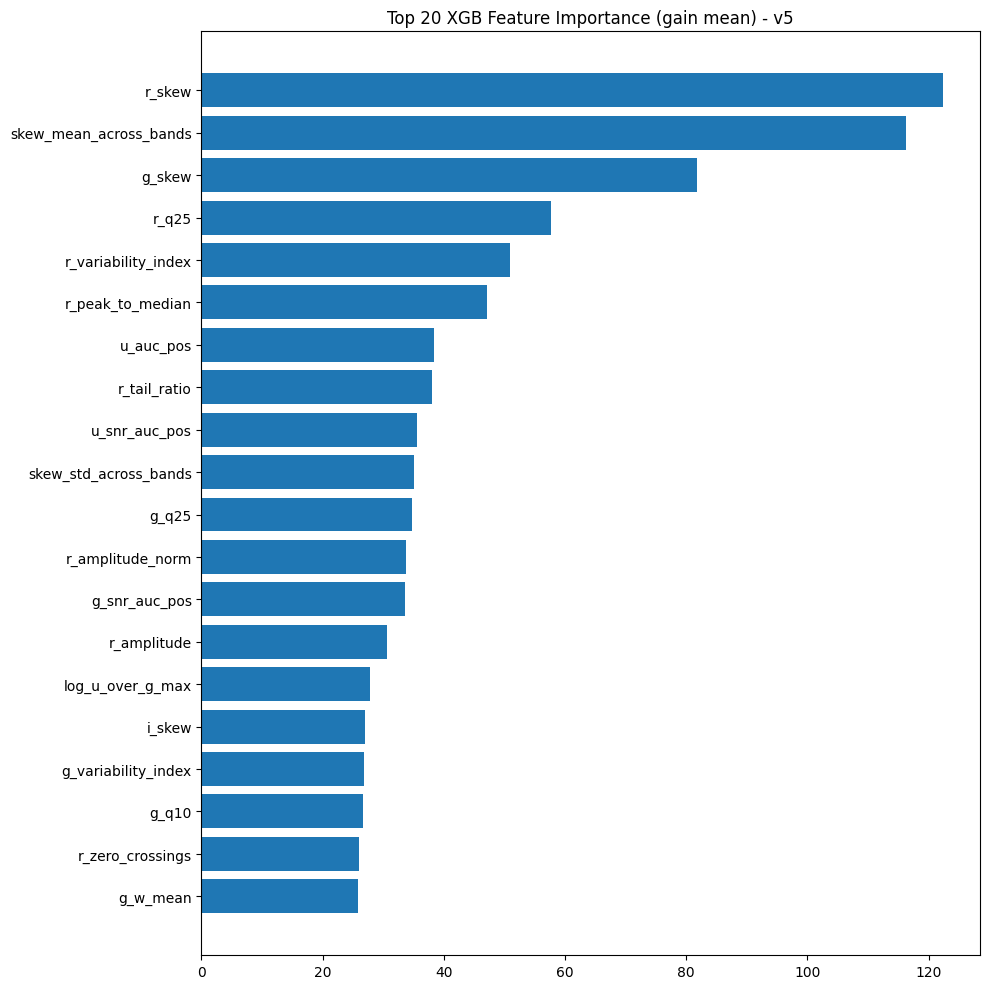

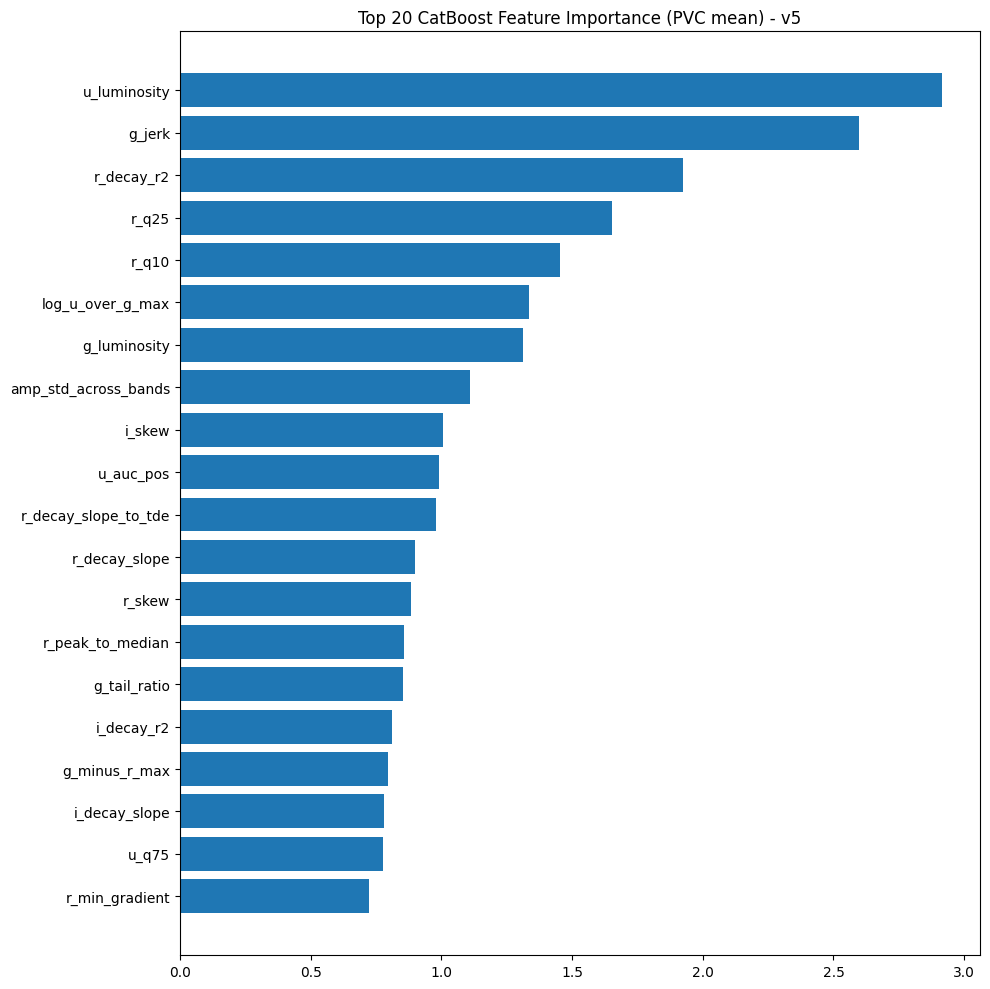

In [15]:
# -------------------------
# 8) FEATURE IMPORTANCE (XGB gain mean)
# -------------------------
print("\n=== Feature importance (XGB gain mean over folds+seeds) ===")

# flatten all gain maps
all_maps = []
for seed_maps in xgb_gain_maps_all:
    all_maps.extend(seed_maps)

gain_mat = np.zeros((len(all_maps), len(feature_names)), dtype=float)
for i, mp in enumerate(all_maps):
    for k, v in mp.items():
        if k in feature_names:
            gain_mat[i, feature_names.index(k)] = float(v)
        elif isinstance(k, str) and k.startswith("f") and k[1:].isdigit():
            idx = int(k[1:])
            if 0 <= idx < len(feature_names):
                gain_mat[i, idx] = float(v)

gain_mean = gain_mat.mean(axis=0)
gain_std  = gain_mat.std(axis=0)

xgb_imp_df = pd.DataFrame({"feature": feature_names, "gain_mean": gain_mean, "gain_std": gain_std})
xgb_imp_df = xgb_imp_df.sort_values("gain_mean", ascending=False).reset_index(drop=True)
print(xgb_imp_df.head(20).to_string(index=False))

# CatBoost importance (PVC mean) nếu có
print("\n=== Feature importance (CatBoost PVC mean over folds+seeds) ===")
if len(cat_imp_list_all) > 0:
    cat_arr = np.vstack(cat_imp_list_all)
    cat_mean = cat_arr.mean(axis=0)
    cat_std  = cat_arr.std(axis=0)
    cat_imp_df = pd.DataFrame({"feature": feature_names, "pvc_mean": cat_mean, "pvc_std": cat_std})
    cat_imp_df = cat_imp_df.sort_values("pvc_mean", ascending=False).reset_index(drop=True)
    print(cat_imp_df.head(20).to_string(index=False))
else:
    print("[INFO] CatBoost importance not available.")

# Plot
top_k = 20
plt.figure(figsize=(10, 10))
plt.barh(xgb_imp_df.head(top_k).iloc[::-1]["feature"], xgb_imp_df.head(top_k).iloc[::-1]["gain_mean"])
plt.title("Top 20 XGB Feature Importance (gain mean) - v5")
plt.tight_layout()
plt.show()

if len(cat_imp_list_all) > 0:
    plt.figure(figsize=(10, 10))
    plt.barh(cat_imp_df.head(top_k).iloc[::-1]["feature"], cat_imp_df.head(top_k).iloc[::-1]["pvc_mean"])
    plt.title("Top 20 CatBoost Feature Importance (PVC mean) - v5")
    plt.tight_layout()
    plt.show()

2.8 biểu đồ Phân phối điểm dự đoán theo nhãn thực tế

Có thể quan sát thấy các sự kiện TDE có xu hướng được xếp hạng với điểm cao hơn so với AGN và SN, phù hợp với chiến lược lựa chọn theo ranking.

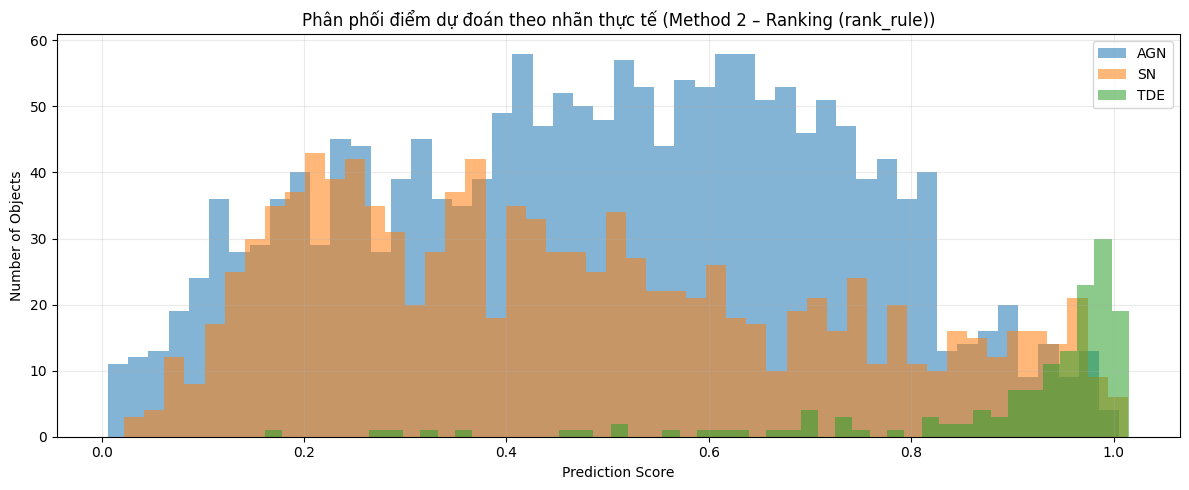

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== 1) CHỌN SCORE MUỐN VẼ ======
scores = build_scores(alpha=best_alpha, wpos=best_wpos, wneg=best_wneg)
oof_score = scores["rank_rule"][0]   # <-- cố định
title_suffix = "Ranking (rank_rule)"

# Nếu muốn vẽ prob_rule thì đổi thành:
# oof_score = scores["prob_rule"][0]
# title_suffix = "Probability (prob_rule)"

assert len(oof_score) == len(full_train_data), "OOF score phải cùng độ dài với train"

# ====== 2) DATAFRAME TRAIN ĐỂ VẼ THEO NHÃN THỰC ======
df = full_train_data[['object_id','target','SpecType']].copy()
df['score'] = oof_score

# map nhóm nhãn cho giống report (AGN / SN / TDE)
def map_group(s):
    if pd.isna(s): return "UNK"
    s = str(s).upper()
    if "AGN" in s: return "AGN"
    if "TDE" in s: return "TDE"
    return "SN"

df['group'] = df['SpecType'].apply(map_group)

# ====== 3) HIST SCORE THEO GROUP ======
plt.figure(figsize=(12,5))
bins = 50

for g in ["AGN","SN","TDE"]:
    x = df.loc[df['group']==g, 'score'].values
    plt.hist(x, bins=bins, alpha=0.55, label=g)

plt.title(f"Phân phối điểm dự đoán theo nhãn thực tế (Method 2 – {title_suffix})")
plt.xlabel("Prediction Score")
plt.ylabel("Number of Objects")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig("method2_score_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

 2.9. phân bố nhãn thực tế trong top 416 (OOF)

- Kết quả cho thấy các sự kiện TDE chiếm khoảng 28.6%, cao hơn đáng kể so với tỷ lệ ban đầu trong toàn bộ tập huấn luyện (~4–5%).

- Điều này cho thấy mô hình đã xếp hạng các ứng viên TDE lên nhóm đầu một cách hiệu quả, phù hợp với chiến lược ranking-first được áp dụng.

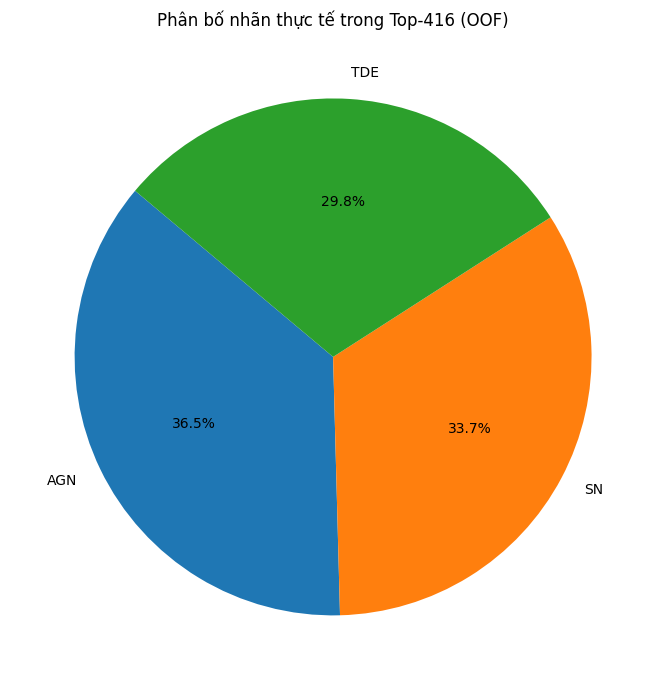

In [17]:
K = 416
topk = df.sort_values("score", ascending=False).head(K)

cnt = topk['group'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(cnt.values, labels=cnt.index, autopct="%.1f%%", startangle=140)
plt.title(f"Phân bố nhãn thực tế trong Top-{K} (OOF)")
plt.tight_layout()
plt.savefig("method2_topk_pie.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()